In [41]:
import psutil
import subprocess
import time
import csv
from datetime import datetime
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA


### Function to check idle thresholds
def calculate_idle_thresholds(group):
    cpu_threshold = group['CPU_Usage'].quantile(0.2)
    gpu_threshold = group['GPU_Usage'].quantile(0.20)
    ram_threshold = group['RAM_Used'].quantile(0.20)
    return pd.Series({
        'cpu_threshold': cpu_threshold,
        'gpu_threshold': gpu_threshold,
        'ram_threshold': ram_threshold
    })

def calculate_value(util_gpu, util_cpu, util_ram, time_diff_seconds, base_value=1.0, max_value=2):
    # Modified formula to keep the adjusted value between 1 and 1.5
    adjusted_value = (
        1 + (0.5 * (
            np.log(1 + (util_gpu - threshold_gpu) / (1 - threshold_gpu)) +
            np.log(1 + (util_cpu - threshold_cpu) / (1 - threshold_cpu)) +
            np.log(1 + (util_ram - threshold_ram) / (1 - threshold_ram))
        ) / 3)
    )
    # Ensure the value remains between 1 and 1.5
    adjusted_value = min(max_value, max(base_value, adjusted_value))
    # Scale the adjusted value by the fraction of the second interval
    return adjusted_value * (time_diff_seconds / 3600)

# Calculate thresholds for eac
### Import data
gaming = pd.read_csv(r'C:\Users\mohda\Documents\Python Scripts\gpu_logging\system_usage_log.csv')


###Drop NAs because I don't like them
gaming = gaming[~gaming.isna()]

### Handle datetime
gaming['Timestamp'] = pd.to_datetime(gaming['Timestamp'], format='%Y-%m-%d %H:%M:%S')

###Convert rams and bytes to GB, MB
bytes = ['RAM_Total','RAM_Available','RAM_Used', 'Bytes_Sent','Bytes_Received']
gaming[bytes]=gaming[bytes].apply(lambda x: x/1073741824)


### Costs 
costs = {'GPU':400, "CPU": 260, "RAM": 130, "SSD": 100}
ts_d = gaming.copy()
ts_d.set_index('Timestamp',inplace=True)
ts_d['hour'] = ts_d.index.hour


### Drop Nans
initial_row_count = len(ts_d)
ts_d.dropna(subset=['Top_GPU_Process', 'CPU_Usage', 'GPU_Usage', 'RAM_Used'], inplace=True)
final_row_count = len(ts_d)
rows_dropped = initial_row_count - final_row_count

print(f"Number of rows dropped: {rows_dropped}")
if ts_d.index.duplicated().any():
    ts_d = ts_d[~ts_d.index.duplicated(keep='first')]  

ts_d.head()


Number of rows dropped: 143330


,CPU_Usage,Memory_Usage,RAM_Total,RAM_Available,RAM_Used,RAM_Percentage,Disk_Usage,GPU_Temperature,GPU_Usage,Bytes_Sent,Bytes_Received,Top_GPU_Process,GPU_Memory_Used_by_Top_Process,hour
Timestamp,,,,,,,,,,,,,,
2024-08-17 20:25:10,7.8,68.0,31.218472,9.997833,21.220638,68.0,68.2,54.0,31.0,1.234836,30.311446,Cult Of The Lamb,[N/A]\r,20
2024-08-17 20:25:13,4.0,67.9,31.218472,10.017269,21.201202,67.9,68.2,54.0,40.0,1.234842,30.311454,Cult Of The Lamb,[N/A]\r,20
2024-08-17 20:25:17,5.6,67.8,31.218472,10.038788,21.179684,67.8,68.2,53.0,35.0,1.234854,30.311461,Cult Of The Lamb,[N/A]\r,20
2024-08-17 20:25:20,4.4,67.7,31.218472,10.069767,21.148705,67.7,68.2,53.0,35.0,1.234887,30.311508,Cult Of The Lamb,[N/A]\r,20
2024-08-17 20:25:23,13.7,68.6,31.218472,9.811050,21.407421,68.6,68.2,53.0,31.0,1.235013,30.311655,Cult Of The Lamb,[N/A]\r,20


C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['state'] = kmeans.fit_predict(usage_data)
C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['is_idle'] = process_data['state'] == idle_cluster


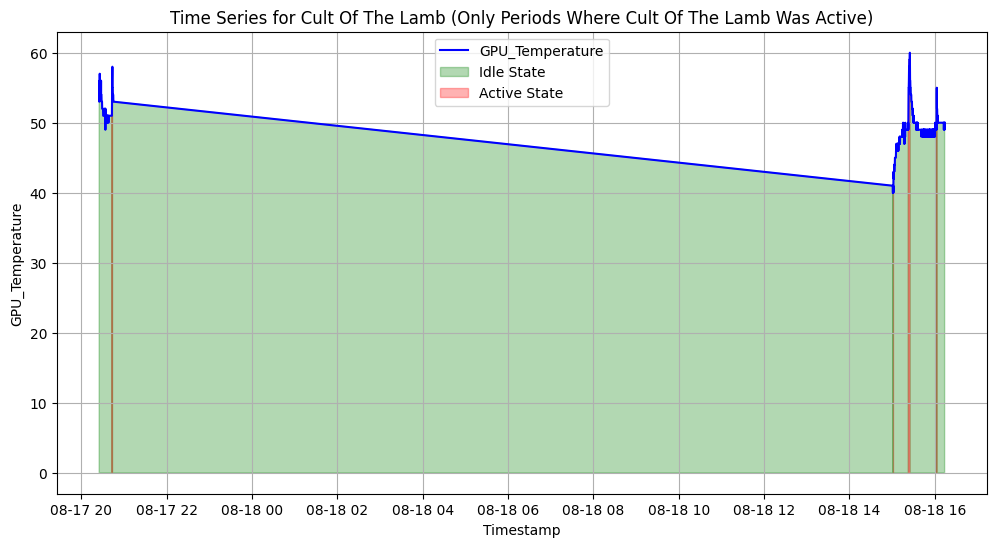

C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['state'] = kmeans.fit_predict(usage_data)
C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['is_idle'] = process_data['state'] == idle_cluster


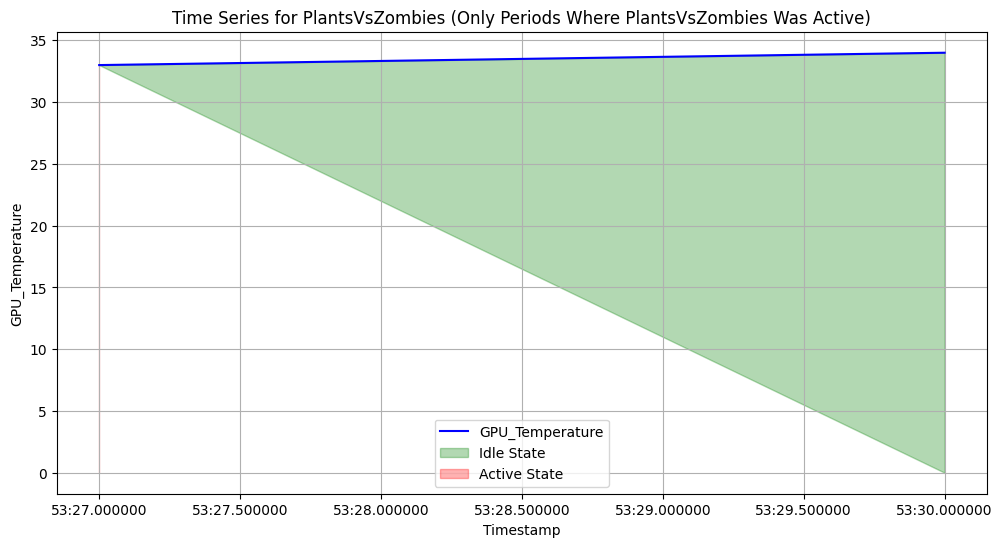

C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['state'] = kmeans.fit_predict(usage_data)
C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['is_idle'] = process_data['state'] == idle_cluster


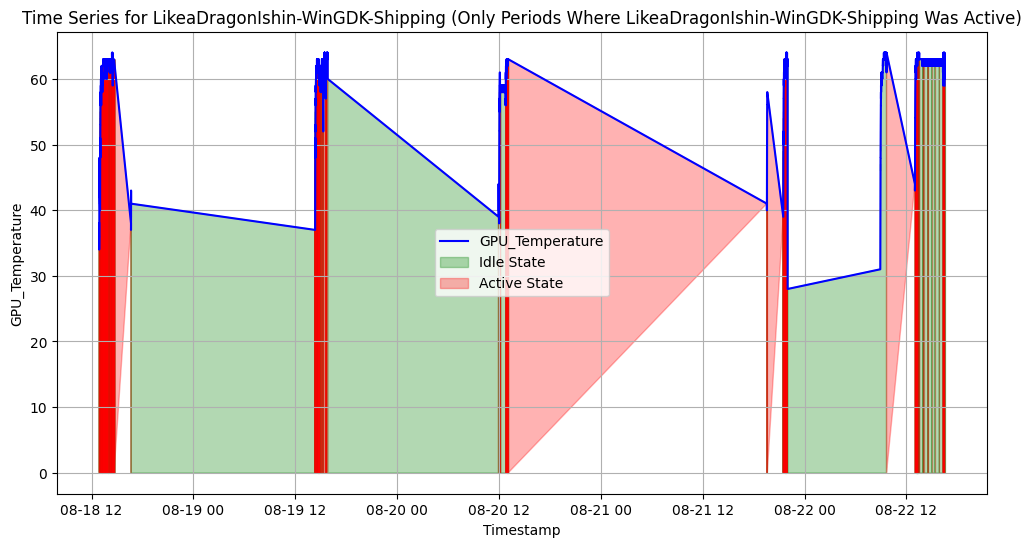

C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['state'] = kmeans.fit_predict(usage_data)
C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['is_idle'] = process_data['state'] == idle_cluster


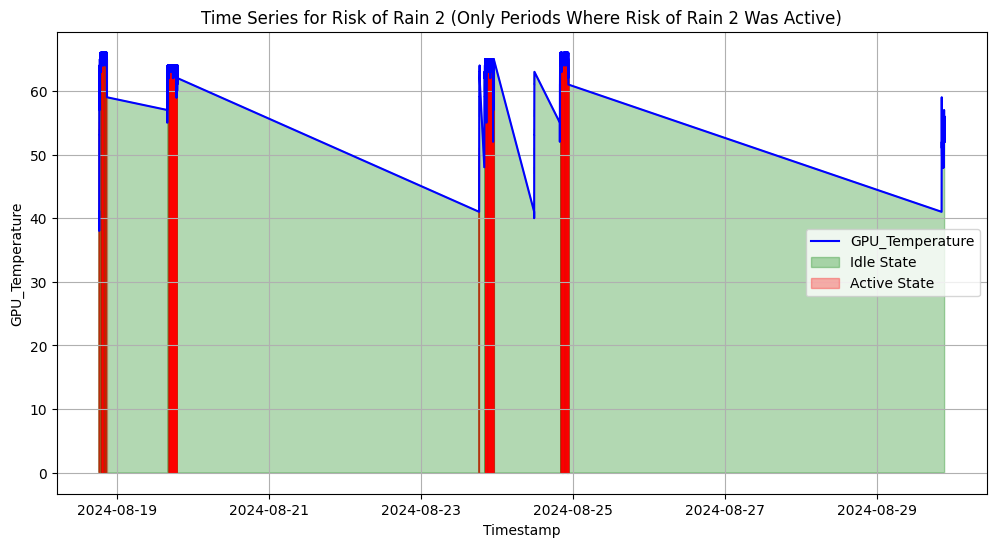

C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['state'] = kmeans.fit_predict(usage_data)
C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['is_idle'] = process_data['state'] == idle_cluster


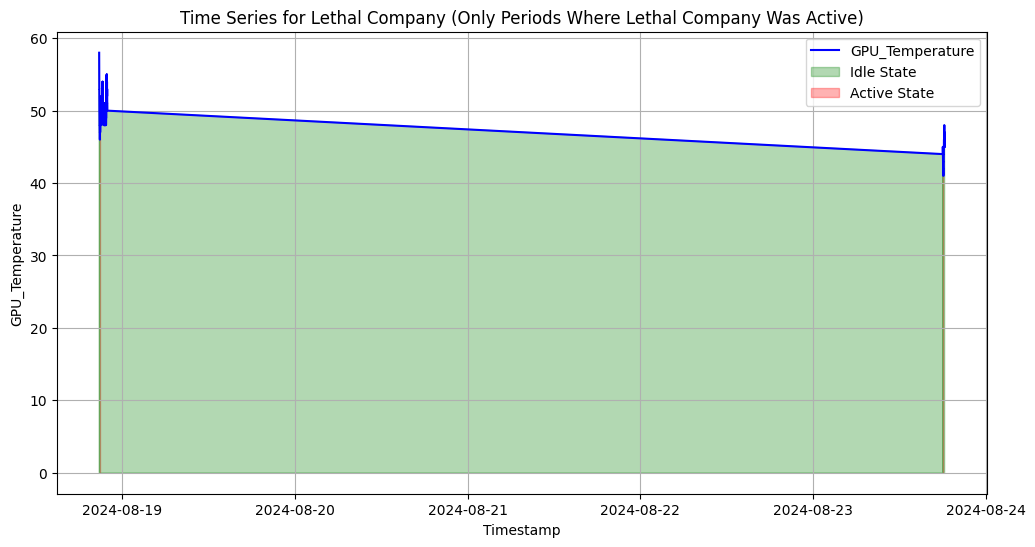

C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['state'] = kmeans.fit_predict(usage_data)
C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['is_idle'] = process_data['state'] == idle_cluster


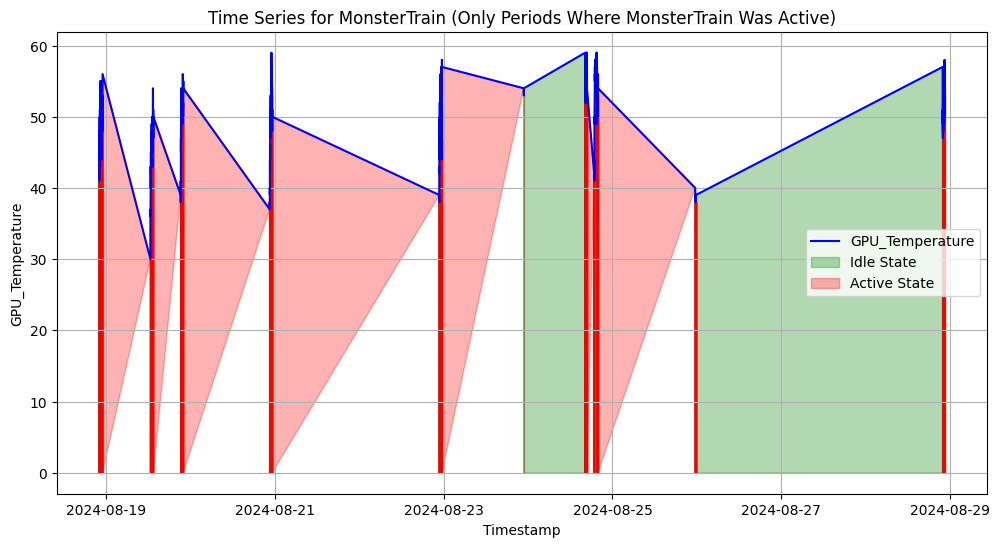

C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['state'] = kmeans.fit_predict(usage_data)
C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['is_idle'] = process_data['state'] == idle_cluster


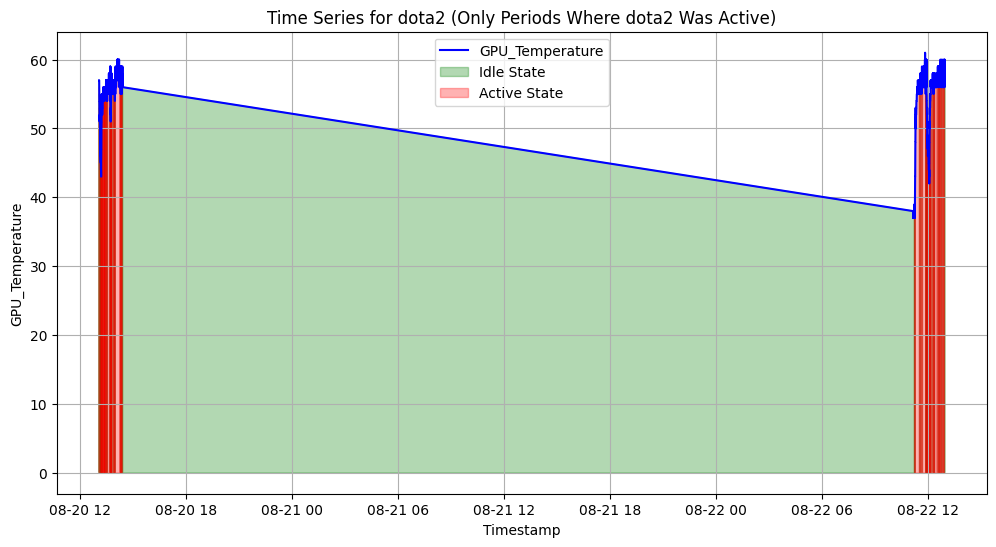

C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['state'] = kmeans.fit_predict(usage_data)
C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['is_idle'] = process_data['state'] == idle_cluster


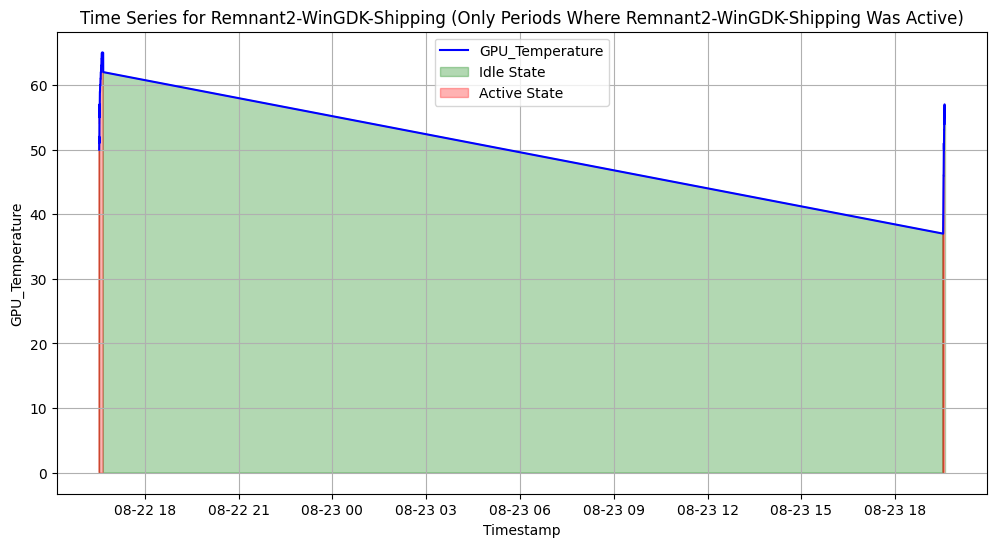

C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['state'] = kmeans.fit_predict(usage_data)
C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['is_idle'] = process_data['state'] == idle_cluster


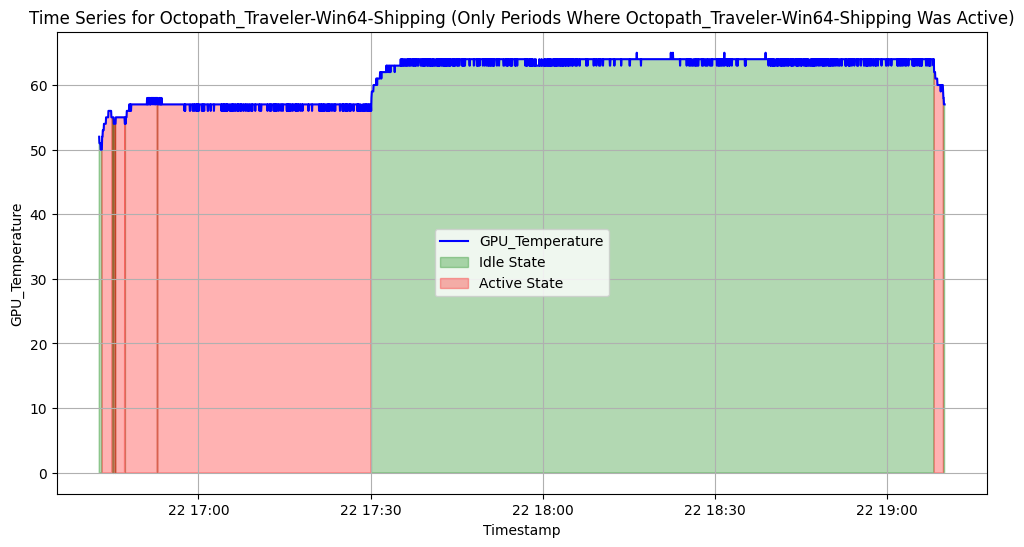

C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['state'] = kmeans.fit_predict(usage_data)
C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['is_idle'] = process_data['state'] == idle_cluster


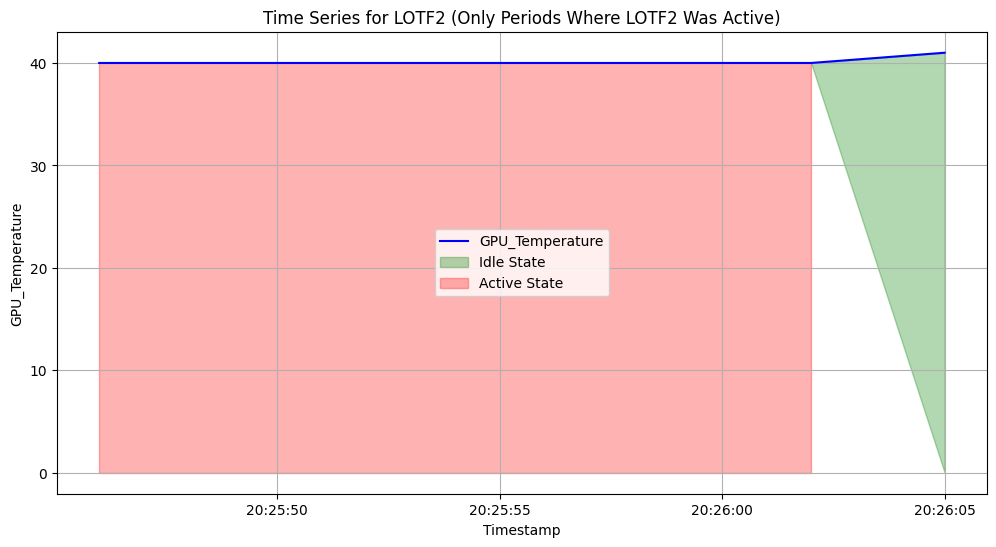

C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['state'] = kmeans.fit_predict(usage_data)
C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['is_idle'] = process_data['state'] == idle_cluster


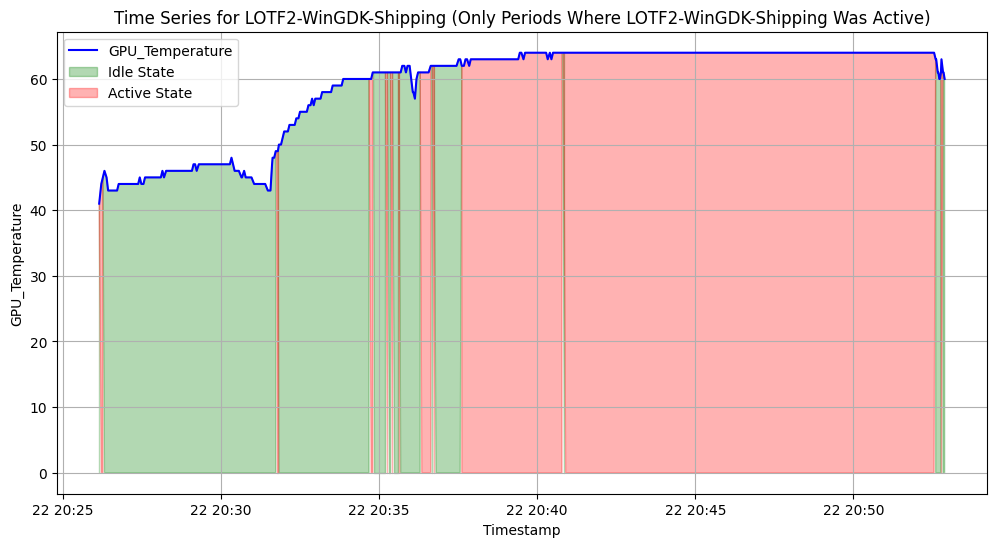

C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['state'] = kmeans.fit_predict(usage_data)
C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['is_idle'] = process_data['state'] == idle_cluster


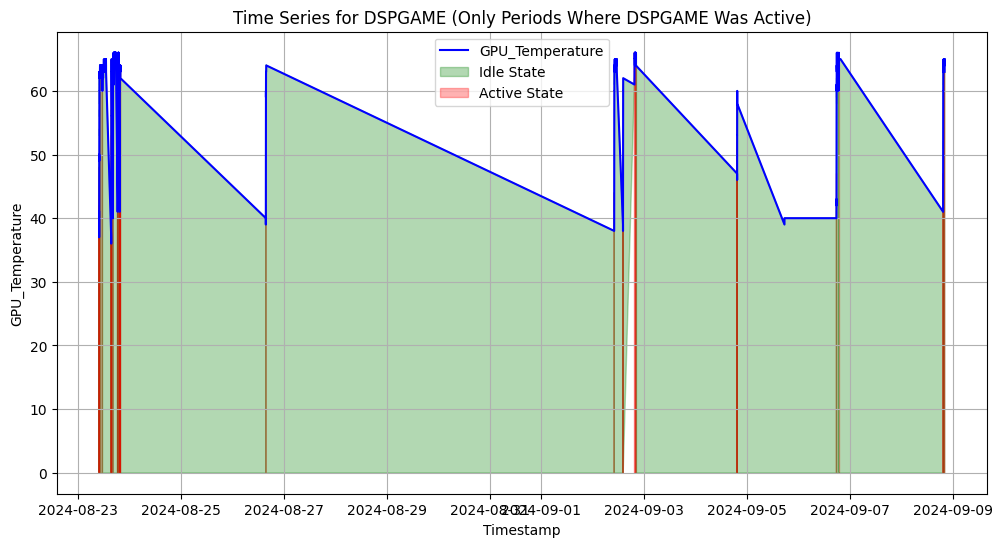

C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['state'] = kmeans.fit_predict(usage_data)
C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['is_idle'] = process_data['state'] == idle_cluster


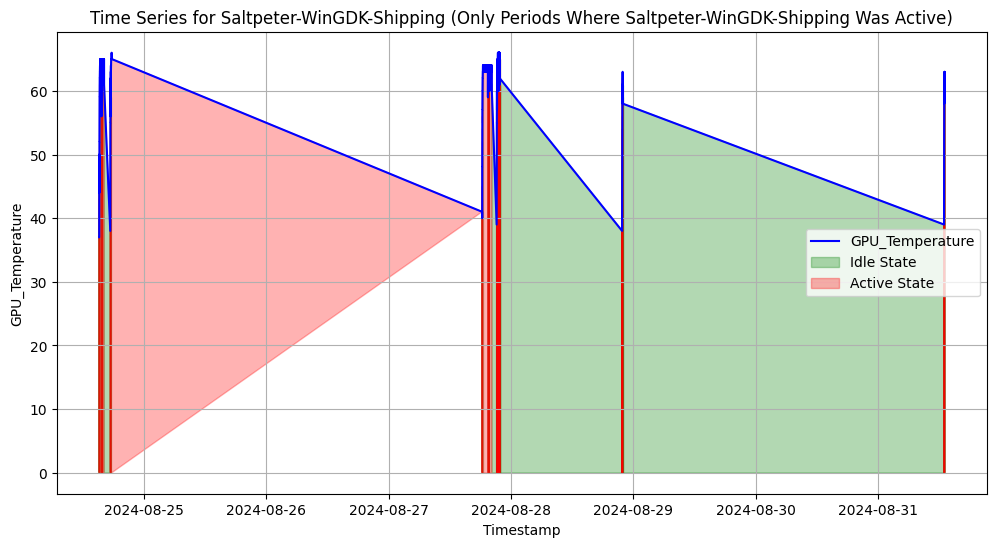

C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['state'] = kmeans.fit_predict(usage_data)
C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['is_idle'] = process_data['state'] == idle_cluster


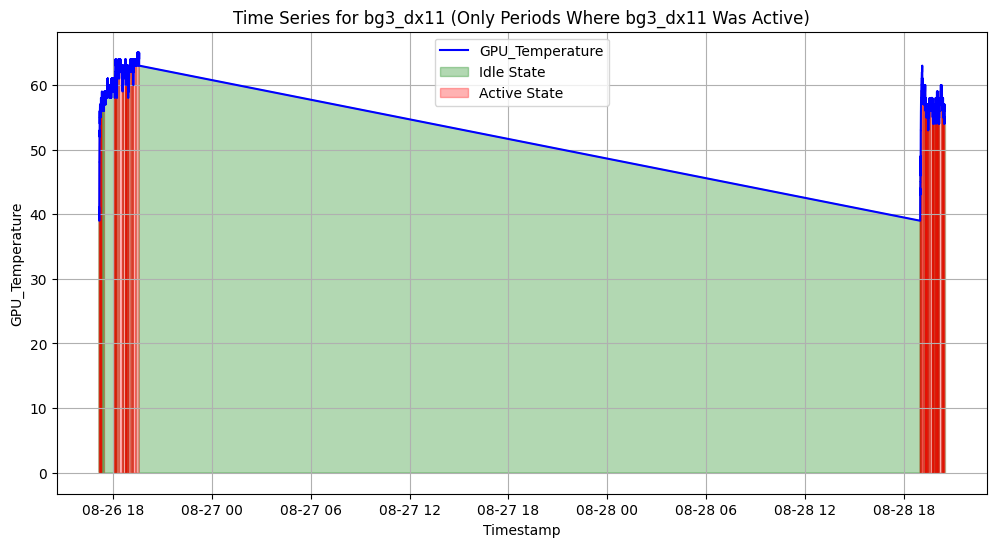

C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['state'] = kmeans.fit_predict(usage_data)
C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['is_idle'] = process_data['state'] == idle_cluster


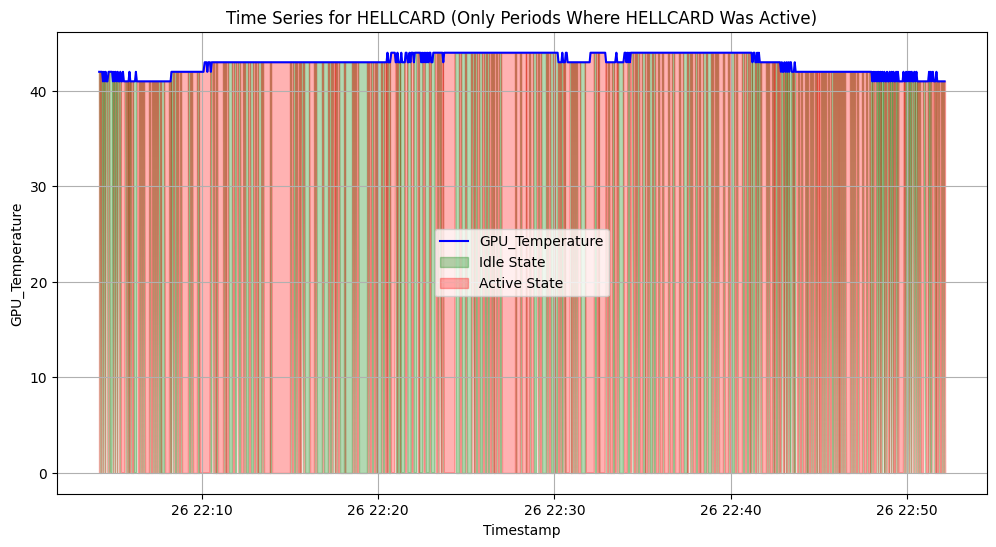

C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['state'] = kmeans.fit_predict(usage_data)
C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['is_idle'] = process_data['state'] == idle_cluster


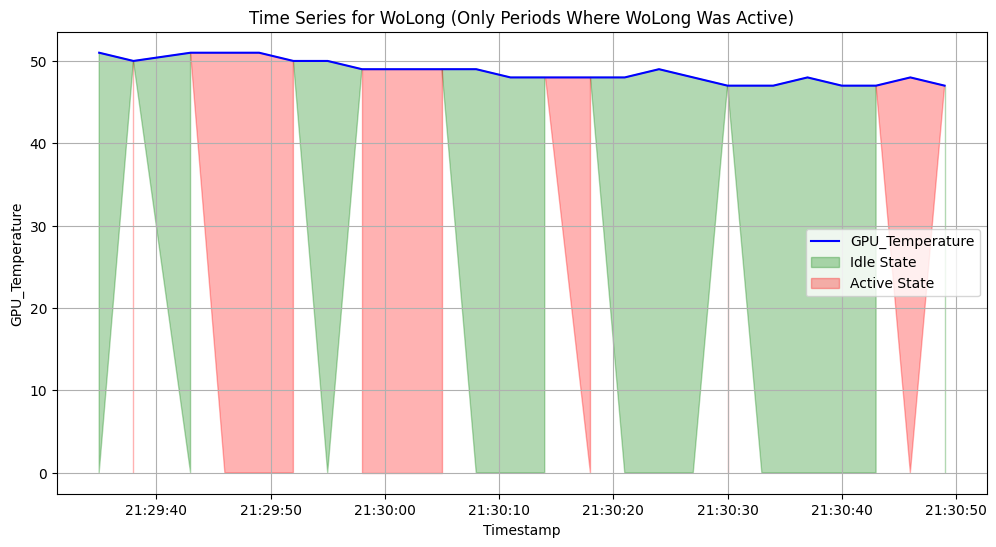

C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['state'] = kmeans.fit_predict(usage_data)
C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['is_idle'] = process_data['state'] == idle_cluster


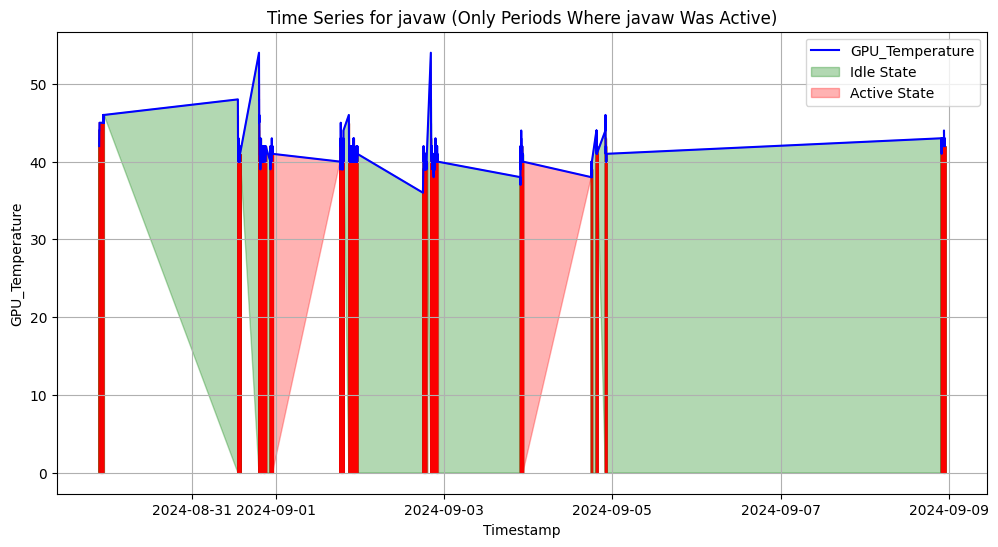

C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['state'] = kmeans.fit_predict(usage_data)
C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['is_idle'] = process_data['state'] == idle_cluster


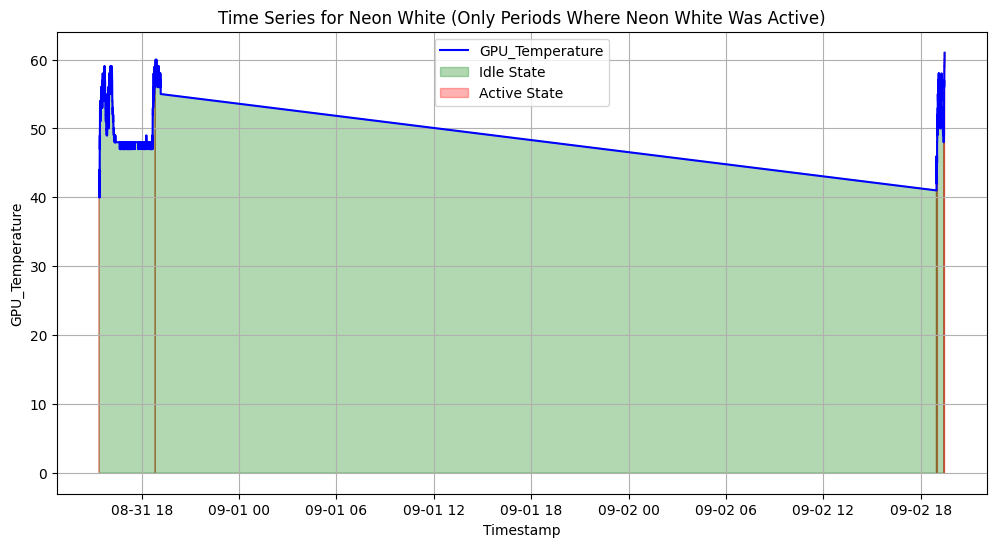

C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['state'] = kmeans.fit_predict(usage_data)
C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['is_idle'] = process_data['state'] == idle_cluster


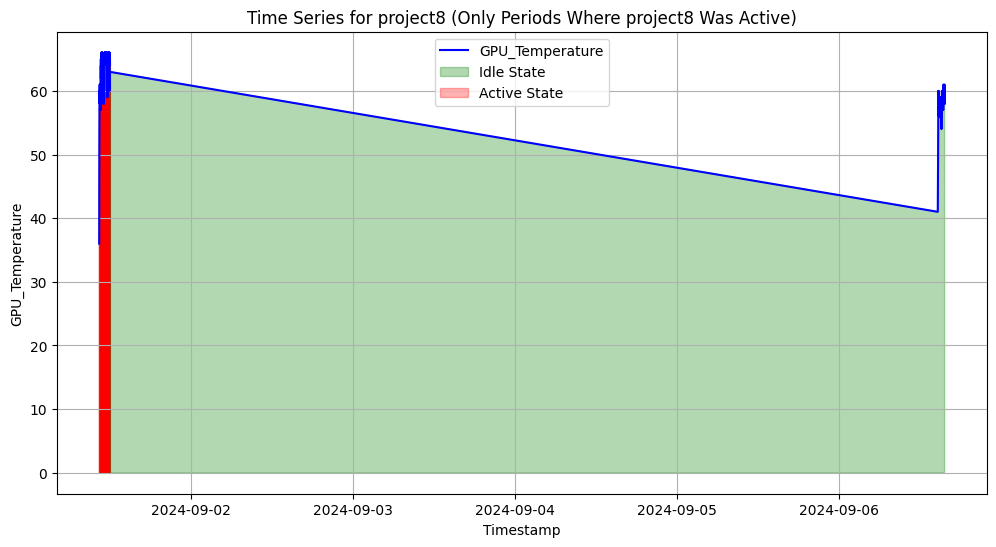

C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['state'] = kmeans.fit_predict(usage_data)
C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['is_idle'] = process_data['state'] == idle_cluster


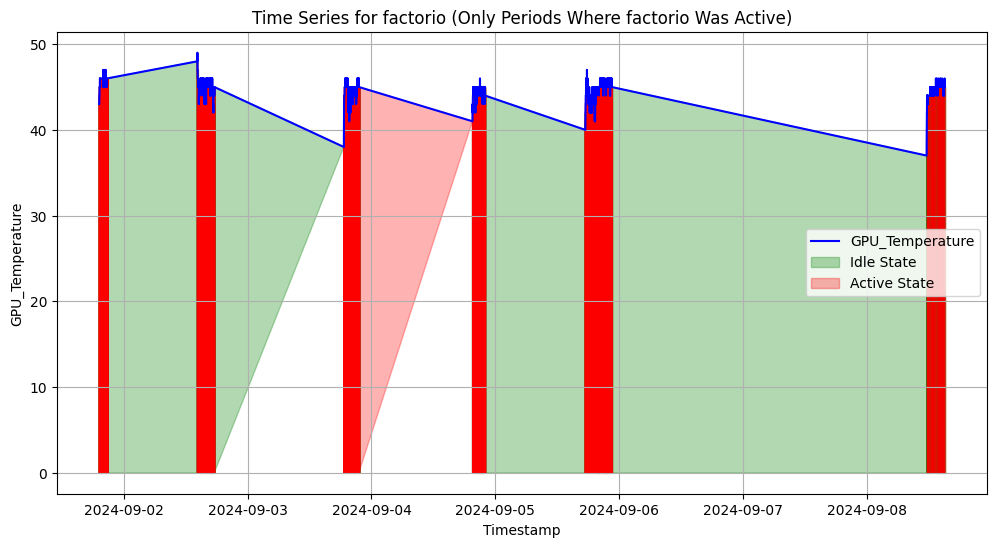

C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['state'] = kmeans.fit_predict(usage_data)
C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\1971896230.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  process_data['is_idle'] = process_data['state'] == idle_cluster


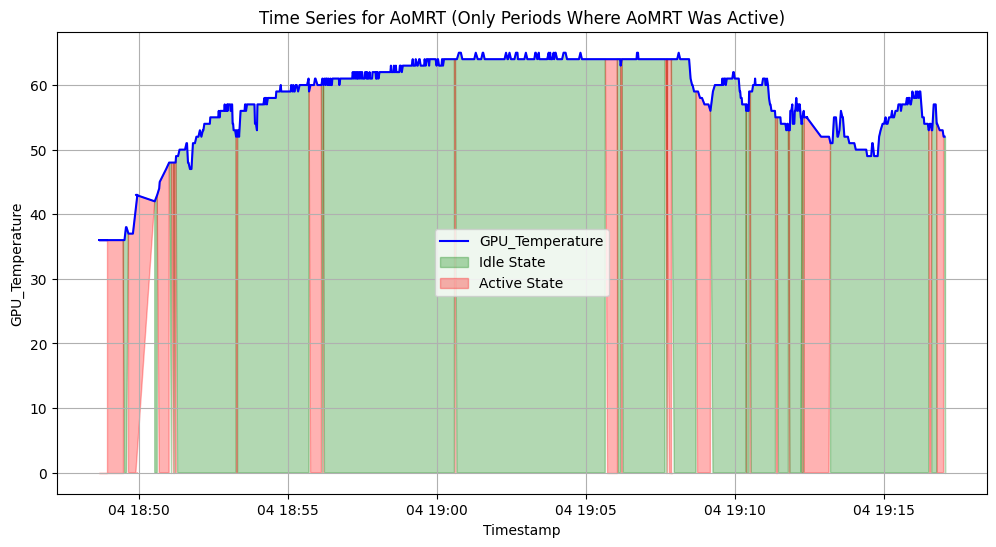

In [42]:
ts_d.dropna(subset=['Top_GPU_Process'], inplace=True)

# Separate the data by Top_GPU_Process and process each process individually
processes = ts_d['Top_GPU_Process'].unique()

for process in processes:
    process_data = ts_d[ts_d['Top_GPU_Process'] == process]

    usage_data = process_data[['CPU_Usage', 'GPU_Usage', 'RAM_Used','Disk_Usage','GPU_Temperature']]

    kmeans = KMeans(n_clusters=2, random_state=0)
    process_data['state'] = kmeans.fit_predict(usage_data)

    cluster_centers = kmeans.cluster_centers_
    idle_cluster = np.argmin(np.sum(cluster_centers, axis=1))  # Cluster with the lowest usage

    process_data['is_idle'] = process_data['state'] == idle_cluster

    plt.figure(figsize=(12, 6))
    plt.plot(process_data.index, process_data['GPU_Temperature'], label='GPU_Temperature', color='blue')
    
    ### Add this is_idle column back to the master dataframe
    ts_d.loc[process_data.index, 'is_idle'] = process_data['is_idle']

    plt.fill_between(
        process_data.index, 
        process_data['GPU_Temperature'], 
        where=process_data['is_idle'], 
        interpolate=True, 
        color='green', 
        alpha=0.3, 
        label='Idle State'
    )
    plt.fill_between(
        process_data.index, 
        process_data['GPU_Temperature'], 
        where=~process_data['is_idle'], 
        interpolate=True, 
        color='red', 
        alpha=0.3, 
        label='Active State'
    )

    plt.title(f'Time Series for {process} (Only Periods Where {process} Was Active)')
    plt.xlabel('Timestamp')
    plt.ylabel('GPU_Temperature')
    plt.legend()
    plt.grid(True)
    plt.show()


In [43]:
### Estimate value. 
value_per_hour = 0.50

threshold_gpu = 0.40  
threshold_cpu = 0.40  
threshold_ram = 0.40  

ts_d[['GPU_Usage', 'CPU_Usage', 'RAM_Percentage']] = ts_d[['GPU_Usage', 'CPU_Usage', 'RAM_Percentage']] / 100

ts_d['time_diff'] = ts_d.index.to_series().diff().fillna(pd.Timedelta(seconds=1))  # Default to 1 second if first entry
ts_d['time_diff_seconds'] = ts_d['time_diff'].dt.total_seconds()  # Convert to seconds


ts_d['hours'] = ts_d['time_diff'].dt.total_seconds() / 3600
active_periods = ts_d[ts_d['is_idle'] == 0]

active_periods['adjusted_value'] = active_periods.apply(
    lambda row: calculate_value(row['GPU_Usage'], row['CPU_Usage'], row['RAM_Used'], row['time_diff_seconds']), axis=1
)

active_periods.head()
total_adjusted_value = active_periods['adjusted_value'].sum()

print(f"Total active hours: {active_periods['hours'].sum():.2f} hours")
print(f"Estimated adjusted value of active gaming time: ${total_adjusted_value:.2f}")


Total active hours: 84.01 hours
Estimated adjusted value of active gaming time: $128.41


C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\2192071796.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_periods['adjusted_value'] = active_periods.apply(


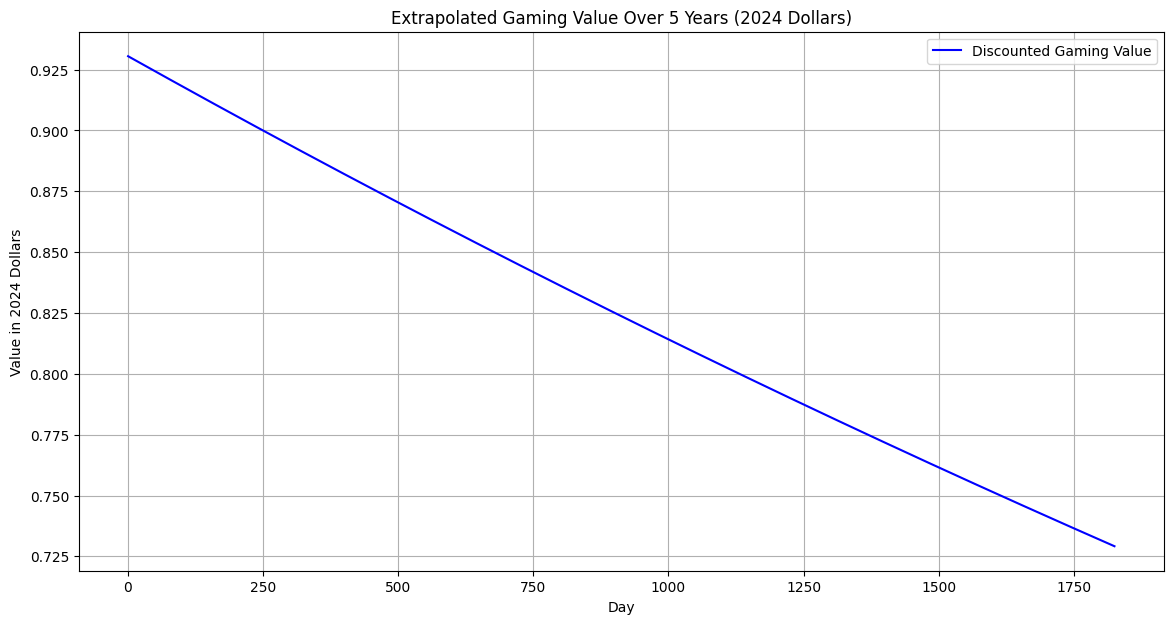

Average gaming time per day: 4.00 hours
Area under the curve (Trapezoid rule): $1506.16


C:\Users\mohda\AppData\Local\Temp\ipykernel_126728\884120710.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_under_curve = np.trapz(df['Discounted Value'], df['Day'])


In [48]:


### Estimate future value


total_active_time_seconds = active_periods['time_diff_seconds'].sum()
unique_days = active_periods.index.normalize().nunique()



average_gaming_time_per_day = (total_active_time_seconds / unique_days) / 3600  # Convert seconds to hours
adjusted_value_per_day = active_periods.resample('D')['adjusted_value'].sum().mean()

annual_discount_rate = 0.05
daily_discount_rate = np.log(1 + annual_discount_rate) / 365

total_days = 5 * 365  # 5 years

days = np.arange(1, total_days + 1)
discount_factors = np.exp(-daily_discount_rate * days)

daily_values = adjusted_value_per_day * (average_gaming_time_per_day / 24) * discount_factors

df = pd.DataFrame({
    'Day': days,
    'Discounted Value': daily_values
})

plt.figure(figsize=(14, 7))
plt.plot(df['Day'], df['Discounted Value'], label='Discounted Gaming Value', color='blue')
plt.title('Extrapolated Gaming Value Over 5 Years (2024 Dollars)')
plt.xlabel('Day')
plt.ylabel('Value in 2024 Dollars')
plt.grid(True)
plt.legend()
plt.show()


area_under_curve = np.trapz(df['Discounted Value'], df['Day'])

print(f"Average gaming time per day: {average_gaming_time_per_day:.2f} hours")
print(f"Area under the curve (Trapezoid rule): ${area_under_curve:.2f}")


In [40]:
unique_days

19

In [ ]:
print("Check Utilization Values Against Thresholds:")
print(active_periods[['RAM_Percentage', 'GPU_Usage', 'CPU_Usage']].describe())

# Check if any values are below thresholds
below_thresholds = active_periods[(active_periods['RAM_Percentage'] <= threshold_ram) & 
                                  (active_periods['GPU_Usage'] <= threshold_gpu) & 
                                  (active_periods['CPU_Usage'] <= threshold_cpu)]
print(f"Number of periods below thresholds: {len(below_thresholds)}")
print(below_thresholds[['RAM_Percentage', 'GPU_Usage', 'CPU_Usage']])

In [ ]:
#Average usage 



def plot_hourly(val):
    ts_h = ts_d.groupby('hour')[val].mean()

    plt.figure(figsize=(10, 6))
    plt.plot(ts_h.index, ts_h.values, marker='o')
    plt.title('Average Value by Hour of the Day')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Value')
    plt.grid(True)
    plt.xticks(ts_h.index)  # Set x-ticks to be each hour
    plt.show()

plot_hourly('GPU_Temperature')

In [28]:
#### Plot 
daily_discount_rate

np.float64(0.0001336716826559782)

In [21]:
total_active_time_seconds

np.float64(609662.0)

In [ ]:
ts_d.groupby('is_idle').size()